In [4]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [5]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.15.0


In [6]:
%cd data/food-101/

C:\Users\Jiang\flask-vue-crud\data\food-101


C:\Users\Jiang\flask-vue-crud\env\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [12]:
# Helper function to download data and extract
def get_data_extract():
  if "data/food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [14]:


import os
print(os.listdir(r'C:\Users\Jiang\flask-vue-crud\data\food-101'))

['images', 'meta']


In [15]:
get_data_extract()

Dataset downloaded!
Extracting data..


'wget' is not recognized as an internal or external command,
operable program or batch file.


Extraction done!


tar: Error opening archive: Failed to open 'food-101.tar.gz'


In [16]:
os.listdir(r'C:\Users\Jiang\flask-vue-crud\data\food-101\images')

['apple_pie',
 'baby_back_ribs',
 'bread_pudding',
 'caesar_salad',
 'cannoli',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'chicken_wing',
 'chocolate_cake',
 'chocolate_mousse_cake',
 'club_sandwich',
 'cupcake',
 'deviled_eggs',
 'donut',
 'dumplings',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'french_fries',
 'french_onion_soup',
 'fried_rice',
 'garlic_bread',
 'gnocchi',
 'grilled_cheese_sandwich',
 'hamburger',
 'hot_dog',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'macaroni_and_cheese',
 'mussels',
 'nachos',
 'omelette',
 'onion_rings',
 'pad_thai',
 'paella',
 'pancakes',
 'peking_duck',
 'pizza',
 'pork_chop',
 'poutine',
 'prime_rib',
 'pulled_pork_sandwich',
 'ramen',
 'ravioli',
 'red_velvet_cake',
 'samosa',
 'scallops',
 'spaghetti_bolognese',
 'spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'tiramisu',
 'waffles']

In [18]:
os.listdir(r'C:\Users\Jiang\flask-vue-crud\data\food-101\meta')

['classes.txt',
 'labels.txt',
 'test.json',
 'test.txt',
 'train.json',
 'train.txt']

In [21]:
# 打开文件，读取前10行
num_lines = 10
with open(r'C:\Users\Jiang\flask-vue-crud\data\food-101\meta\train.txt', 'r') as file:
    for i, line in enumerate(file):
        if i >= num_lines:
            break
        print(line.strip())  # strip() 移除行尾的换行符


apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [22]:
# 打开文件，读取前10行
num_lines = 10
with open(r'C:\Users\Jiang\flask-vue-crud\data\food-101\meta\classes.txt', 'r') as file:
    for i, line in enumerate(file):
        if i >= num_lines:
            break
        print(line.strip())

apple_pie
baby_back_ribs
bread_pudding
caesar_salad
cannoli
carrot_cake
ceviche
cheesecake
chicken_wings
chocolate_cake


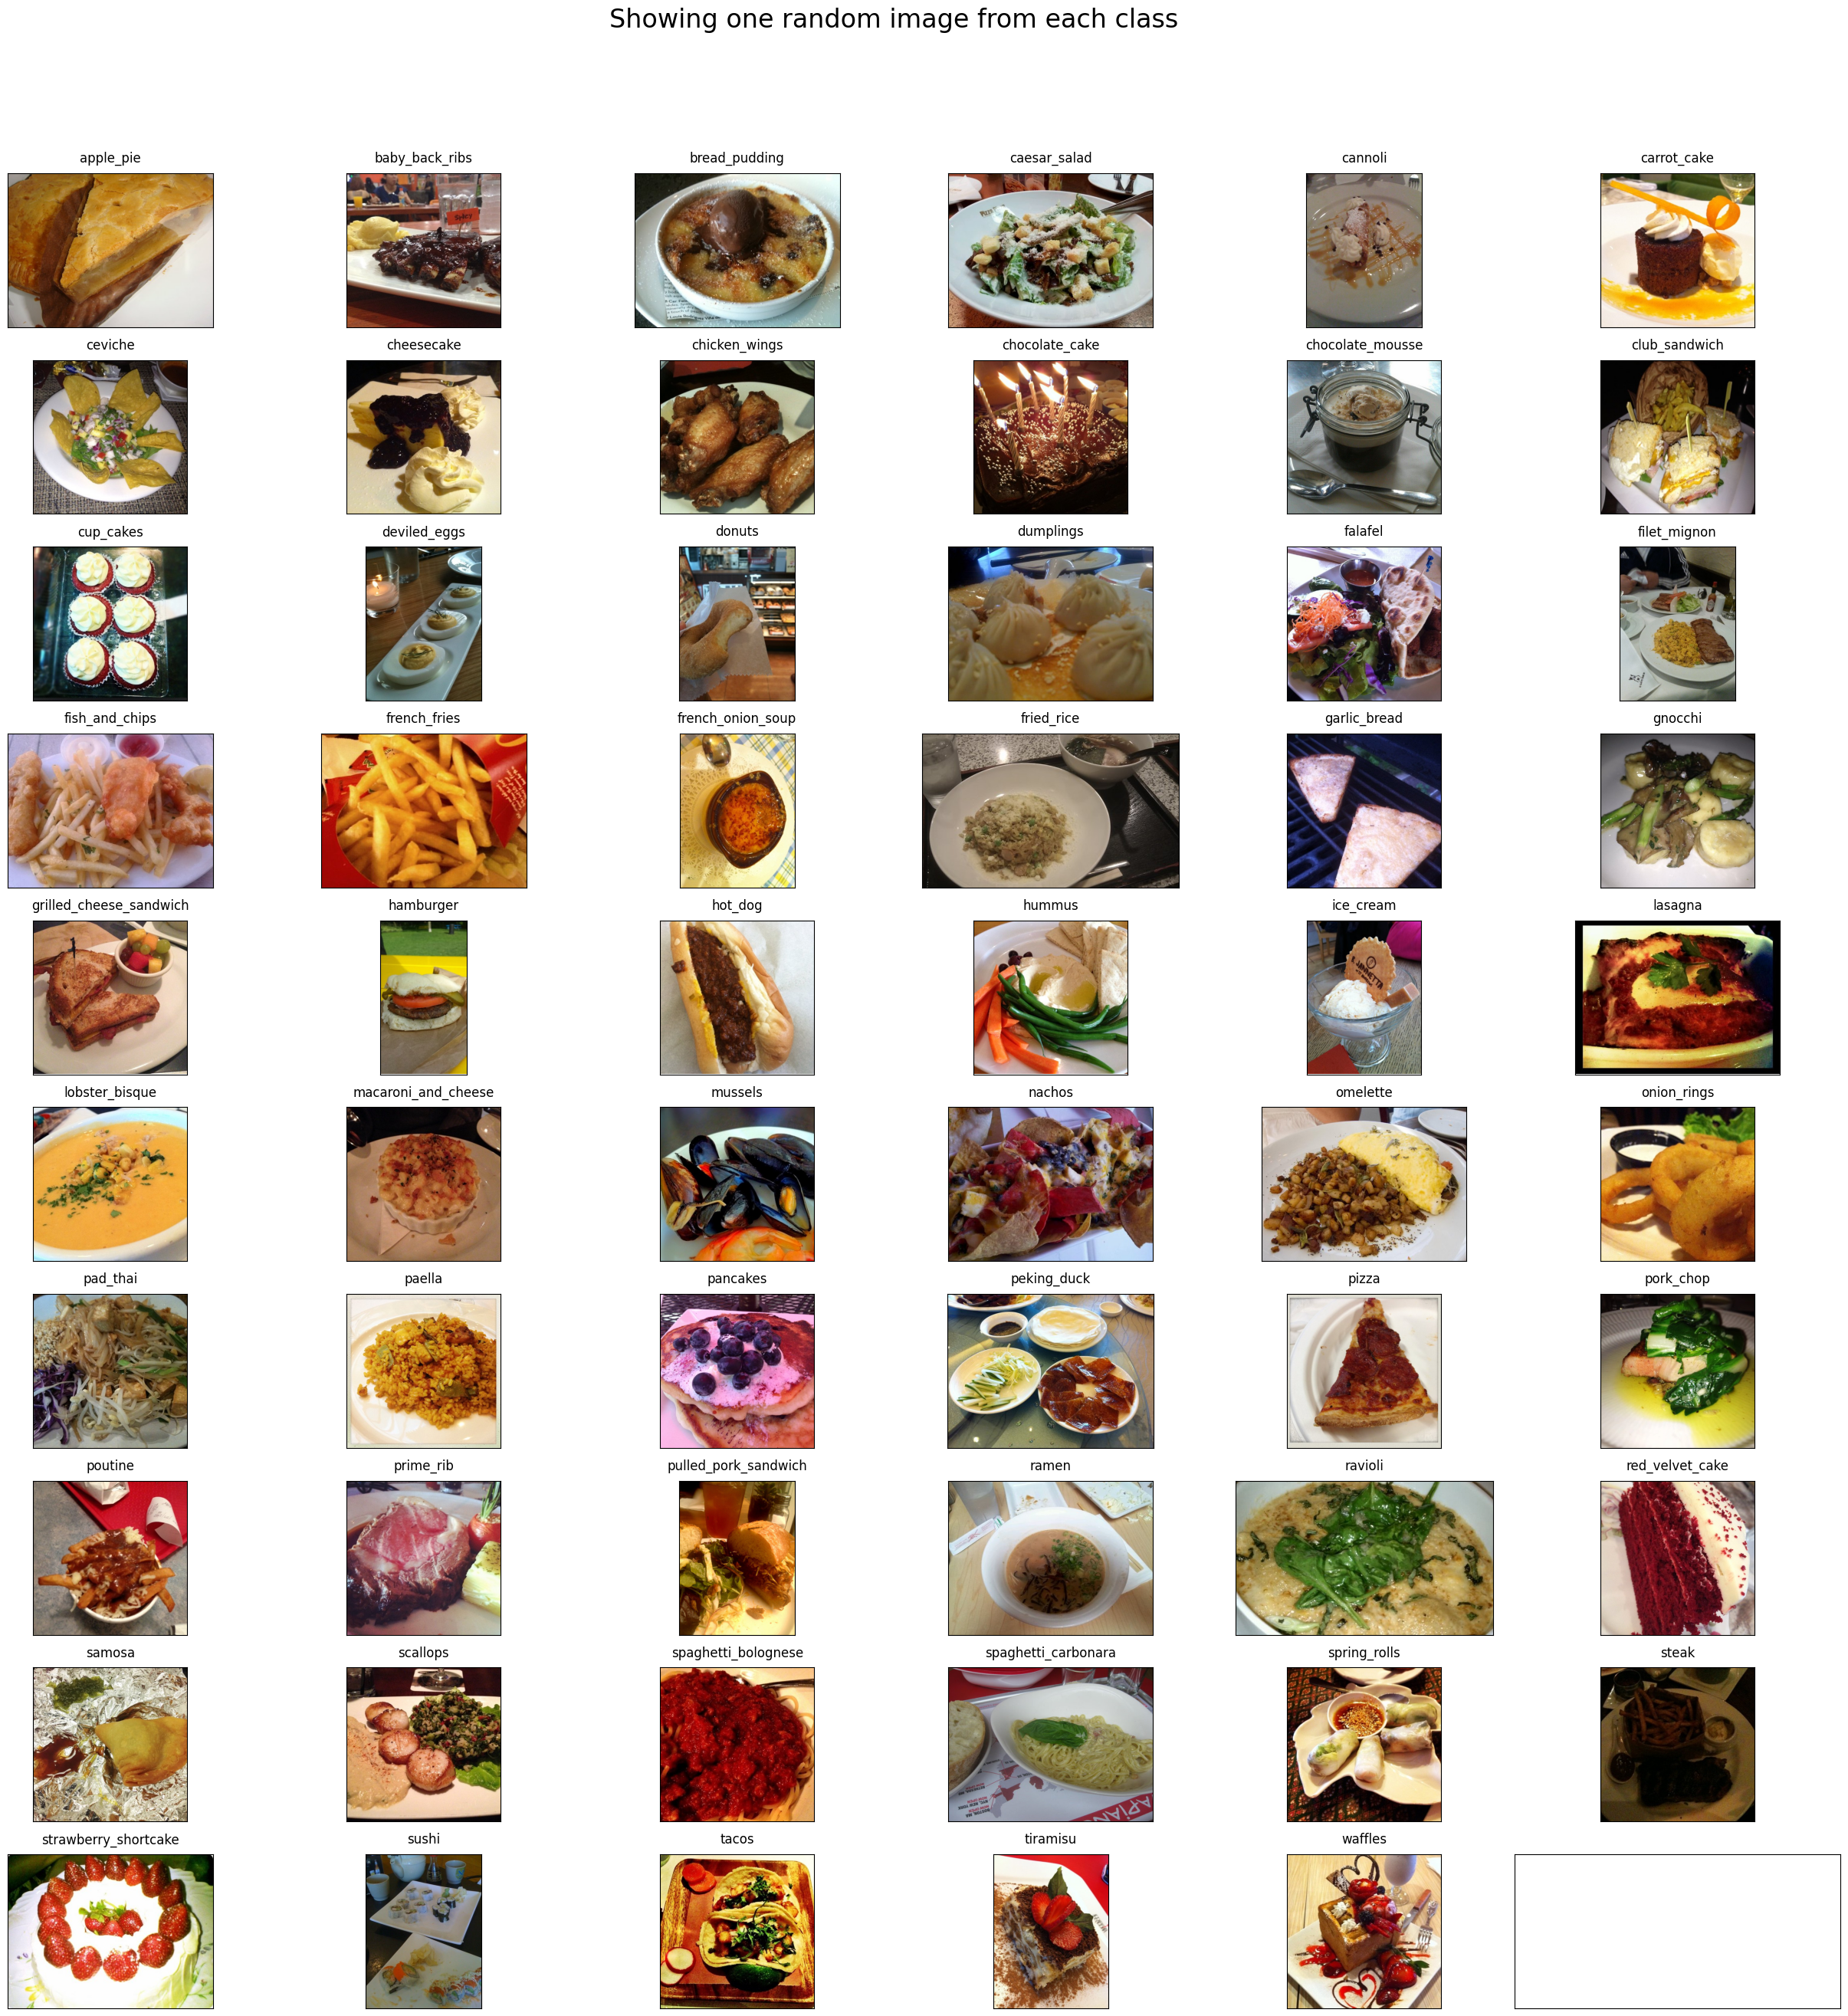

In [24]:
# Visualize the data, showing one image per class from 101 classes
rows = 10
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = r'C:\Users\Jiang\flask-vue-crud\data\food-101\images'
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [25]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [26]:
print("Creating train data...")
prepare_data(r'C:\Users\Jiang\flask-vue-crud\data\food-101\meta\train.txt', r'C:\Users\Jiang\flask-vue-crud\data\food-101\images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  bread_pudding

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  club_sandwich

Copying images into  cup_cakes

Copying images into  deviled_eggs

Copying images into  donuts

Copying images into  dumplings

Copying images into  falafel

Copying images into  filet_mignon

Copying images into  fish_and_chips

Copying images into  french_fries

Copying images into  french_onion_soup

Copying images into  fried_rice

Copying images into  garlic_bread

Copying images into  gnocchi

Copying images into  grilled_cheese_sandwich

Copying images into  hamburger

Copying images into  hot_dog

Copying images into  hummus

Copying images into  

In [27]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data(r'C:\Users\Jiang\flask-vue-crud\data\food-101\meta\test.txt', r'C:\Users\Jiang\flask-vue-crud\data\food-101\images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  bread_pudding

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  club_sandwich

Copying images into  cup_cakes

Copying images into  deviled_eggs

Copying images into  donuts

Copying images into  dumplings

Copying images into  falafel

Copying images into  filet_mignon

Copying images into  fish_and_chips

Copying images into  french_fries

Copying images into  french_onion_soup

Copying images into  fried_rice

Copying images into  garlic_bread

Copying images into  gnocchi

Copying images into  grilled_cheese_sandwich

Copying images into  hamburger

Copying images into  hot_dog

Copying images into  hummus

Copying images into  i

In [29]:
import os

def count_files_and_directories(directory):
    """Counts the number of files and directories in the given directory."""
    total_count = 0
    for base, dirs, files in os.walk(directory):
        # +1 for each directory (including the root directory)
        total_count += len(dirs) + len(files)
    return total_count

# Replace 'train' with the path to your train directory
train_folder = 'train'  # 修改为你的训练文件夹路径
total_count = count_files_and_directories(train_folder)
print(f"Total number of samples in train folder: {total_count}")


Total number of samples in train folder: 44309


In [30]:
import os

def count_files_and_directories(directory):
    """Counts the number of files and directories in the given directory."""
    total_count = 0
    for base, dirs, files in os.walk(directory):
        # +1 for each directory (including the root directory)
        total_count += len(dirs) + len(files)
    return total_count

# Replace 'train' with the path to your train directory
train_folder = 'test'  # 修改为你的训练文件夹路径
total_count = count_files_and_directories(train_folder)
print(f"Total number of samples in train folder: {total_count}")

Total number of samples in train folder: 14809


In [31]:
del foods_sorted[0]

In [32]:
foods_sorted

['baby_back_ribs',
 'bread_pudding',
 'caesar_salad',
 'cannoli',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'club_sandwich',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'french_fries',
 'french_onion_soup',
 'fried_rice',
 'garlic_bread',
 'gnocchi',
 'grilled_cheese_sandwich',
 'hamburger',
 'hot_dog',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'macaroni_and_cheese',
 'mussels',
 'nachos',
 'omelette',
 'onion_rings',
 'pad_thai',
 'paella',
 'pancakes',
 'peking_duck',
 'pizza',
 'pork_chop',
 'poutine',
 'prime_rib',
 'pulled_pork_sandwich',
 'ramen',
 'ravioli',
 'red_velvet_cake',
 'samosa',
 'scallops',
 'spaghetti_bolognese',
 'spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'tiramisu',
 'waffles']

In [33]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger


In [35]:
# Define paths
train_data_dir = 'train'  # Adjust to your own dataset path
validation_data_dir = 'test'  # Adjust to your own dataset path
n_classes = 59  # Change this to the number of classes you have, e.g., 59 for your case


In [36]:

# Define image processors for augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [37]:
# Define image loaders
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')


Found 44250 images belonging to 59 classes.
Found 14750 images belonging to 59 classes.


In [38]:
# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)


94765736/94765736 [==============================] - 6s 0us/step


In [39]:

# Extend the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  # Regularize with dropout
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [40]:
# Compile the model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
# Callbacks
checkpoint = ModelCheckpoint(filepath=r'C:\Users\Jiang\flask-vue-crud\data\food-101\best_model.hdf5',  # Adjust the path
                             verbose=1,
                             save_best_only=True)
csv_logger = CSVLogger(r'C:\Users\Jiang\flask-vue-crud\data\food-101\training.log')  # Adjust the path


In [42]:
# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # You may want to change the number of epochs
    callbacks=[csv_logger, checkpoint])

C:\Users\Jiang\AppData\Local\Temp\ipykernel_16736\3368246065.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10


2765/2765 [==============================] - ETA: 0s - loss: 2.4626 - accuracy: 0.3616
Epoch 1: val_loss improved from inf to 2.87091, saving model to C:\Users\Jiang\flask-vue-crud\data\food-101\best_model.hdf5


C:\Users\Jiang\flask-vue-crud\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2765/2765 [==============================] - 8385s 3s/step - loss: 2.4626 - accuracy: 0.3616 - val_loss: 2.8709 - val_accuracy: 0.3393
Epoch 2/10
2765/2765 [==============================] - ETA: 0s - loss: 1.6790 - accuracy: 0.5459
Epoch 2: val_loss improved from 2.87091 to 1.46985, saving model to C:\Users\Jiang\flask-vue-crud\data\food-101\best_model.hdf5
2765/2765 [==============================] - 8254s 3s/step - loss: 1.6790 - accuracy: 0.5459 - val_loss: 1.4698 - val_accuracy: 0.6030
Epoch 3/10
2765/2765 [==============================] - ETA: 0s - loss: 1.3928 - accuracy: 0.6166
Epoch 3: val_loss did not improve from 1.46985
2765/2765 [==============================] - 8257s 3s/step - loss: 1.3928 - accuracy: 0.6166 - val_loss: 1.5284 - val_accuracy: 0.5854
Epoch 4/10
2765/2765 [==============================] - ETA: 0s - loss: 1.1910 - accuracy: 0.6694
Epoch 4: val_loss did not improve from 1.46985
2765/2765 [==============================] - 8310s 3s/step - loss: 1.1910 - acc

In [44]:
model.save(r'C:\Users\Jiang\flask-vue-crud\data\food-101\final_model.hdf5') 

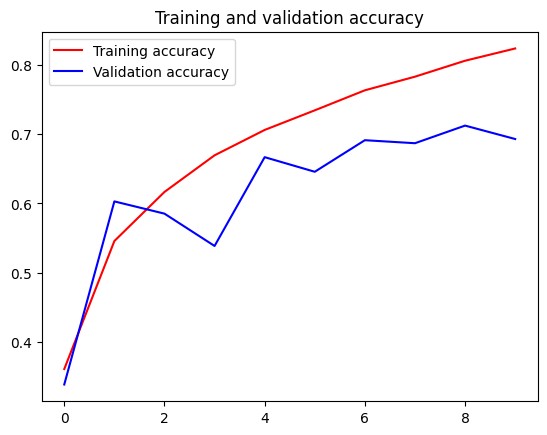

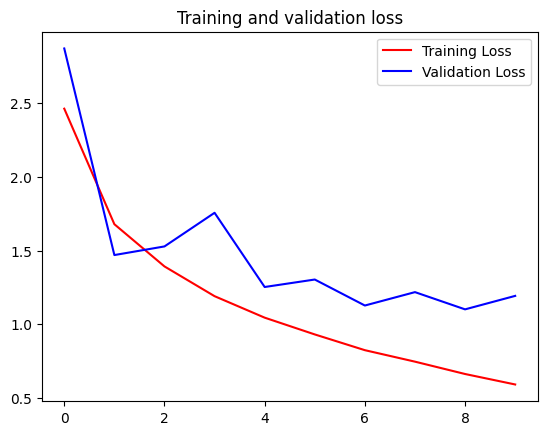

In [45]:
# Plot training results
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training(history)

In [46]:
K.clear_session()
model_best = load_model(r'C:\Users\Jiang\flask-vue-crud\data\food-101\final_model.hdf5', compile = False)


In [49]:
import requests

def download_image(image_url, target_path):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    response = requests.get(image_url, stream=True, headers=headers)
    if response.status_code == 200:
        with open(target_path, 'wb') as out_file:
            out_file.write(response.content)
    else:
        print("Error downloading image", response.status_code)

download_image("https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg", "cupcakes.jpg")
download_image("https://www.sidechef.com/recipe/b75f5913-ca28-41a7-b985-30ab40045d7a.jpg?d=1408x1120", "springrolls.jpg")
download_image("https://c1.staticflickr.com/1/84/262952165_7ba3466108_z.jpg?zz=1", "garlicbread.jpg")



In [57]:
class_map_11 = train_generator.class_indices
class_map_11

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'bread_pudding': 2,
 'caesar_salad': 3,
 'cannoli': 4,
 'carrot_cake': 5,
 'ceviche': 6,
 'cheesecake': 7,
 'chicken_wings': 8,
 'chocolate_cake': 9,
 'chocolate_mousse': 10,
 'club_sandwich': 11,
 'cup_cakes': 12,
 'deviled_eggs': 13,
 'donuts': 14,
 'dumplings': 15,
 'falafel': 16,
 'filet_mignon': 17,
 'fish_and_chips': 18,
 'french_fries': 19,
 'french_onion_soup': 20,
 'fried_rice': 21,
 'garlic_bread': 22,
 'gnocchi': 23,
 'grilled_cheese_sandwich': 24,
 'hamburger': 25,
 'hot_dog': 26,
 'hummus': 27,
 'ice_cream': 28,
 'lasagna': 29,
 'lobster_bisque': 30,
 'macaroni_and_cheese': 31,
 'mussels': 32,
 'nachos': 33,
 'omelette': 34,
 'onion_rings': 35,
 'pad_thai': 36,
 'paella': 37,
 'pancakes': 38,
 'peking_duck': 39,
 'pizza': 40,
 'pork_chop': 41,
 'poutine': 42,
 'prime_rib': 43,
 'pulled_pork_sandwich': 44,
 'ramen': 45,
 'ravioli': 46,
 'red_velvet_cake': 47,
 'samosa': 48,
 'scallops': 49,
 'spaghetti_bolognese': 50,
 'spaghetti_carb

In [59]:
# Assuming foods_sorted is incorrect or not defined as expected
foods_sorted = list(class_map_11.keys())  # Using the class names from class_map_11

# Helper function to select n random food classes
def pick_n_random_classes(n, total_classes, class_list):
    food_list = []
    random_food_indices = random.sample(range(total_classes), n)  # Adjusted the range
    for i in random_food_indices:
        food_list.append(class_list[i])
    food_list.sort()
    return food_list

# Get the total number of classes from the class indices
total_classes = len(class_map_11)  # use the length of class_map_11 as the total classes

# Pick n random classes
n = 59  # Or however many classes you want to pick, as long as n <= total_classes
if n <= total_classes:
    food_list = pick_n_random_classes(n, total_classes, foods_sorted)
    print("These are the randomly picked food classes we will be training the model on...\n", food_list)
else:
    print(f"Can't pick {n} classes out of {total_classes} total classes. Please choose a smaller number.")




These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'baby_back_ribs', 'bread_pudding', 'caesar_salad', 'cannoli', 'carrot_cake', 'ceviche', 'cheesecake', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'club_sandwich', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'falafel', 'filet_mignon', 'fish_and_chips', 'french_fries', 'french_onion_soup', 'fried_rice', 'garlic_bread', 'gnocchi', 'grilled_cheese_sandwich', 'hamburger', 'hot_dog', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'macaroni_and_cheese', 'mussels', 'nachos', 'omelette', 'onion_rings', 'pad_thai', 'paella', 'pancakes', 'peking_duck', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'samosa', 'scallops', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'tiramisu', 'waffles']


1/1 [==============================] - 1s 1s/step


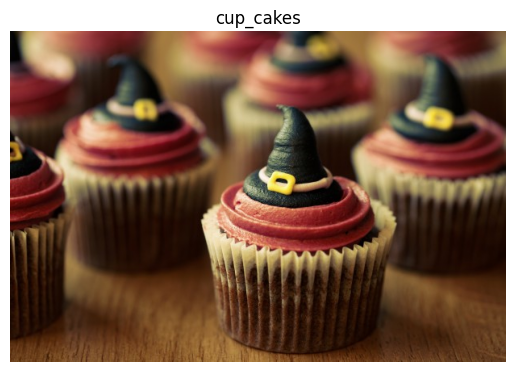

1/1 [==============================] - 0s 148ms/step


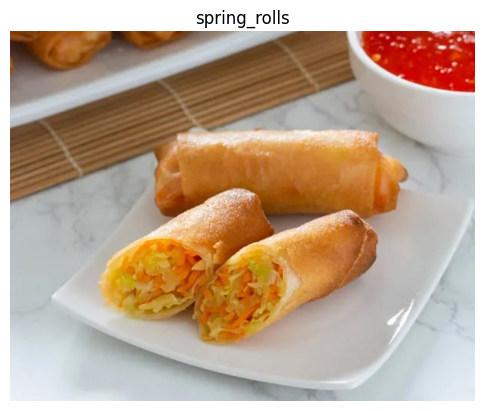

1/1 [==============================] - 0s 185ms/step


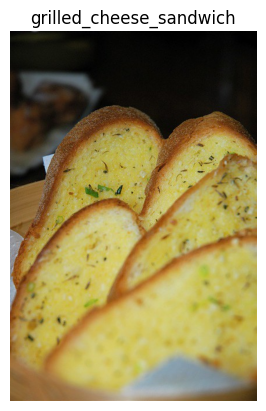

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# 定义模型路径
model_path = r'C:\Users\Jiang\flask-vue-crud\data\food-101\final_model.hdf5'  # Adjust with your model's filepath

# 加载模型
model = load_model(model_path)

# 定义预测函数
def predict_class(model, images, show = True):
  for img_path in images:
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    pred_value = food_list[index]
    if show:
        img_plot = plt.imread(img_path)
        plt.imshow(img_plot)                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

# 创建下载的图片列表并测试训练好的模型
images = ['cupcakes.jpg', 'springrolls.jpg', 'garlicbread.jpg']
predict_class(model, images, True)


1/1 [==============================] - 1s 1s/step


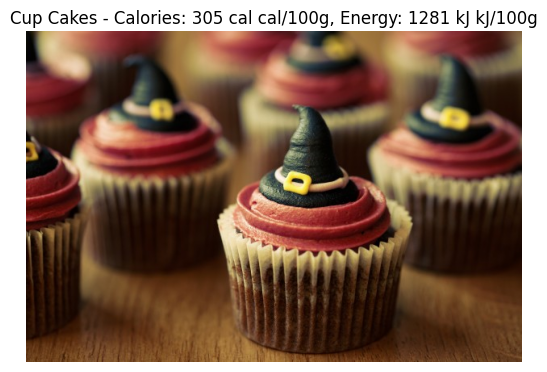

1/1 [==============================] - 0s 221ms/step


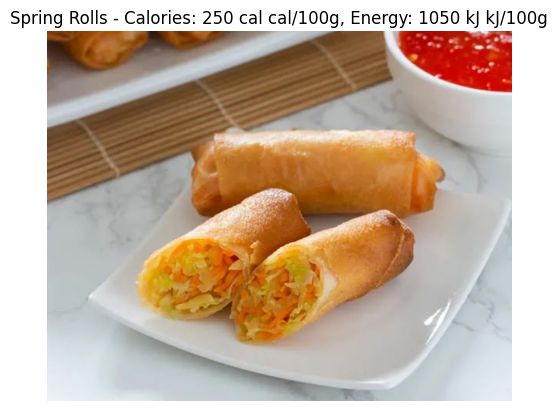

1/1 [==============================] - 0s 168ms/step


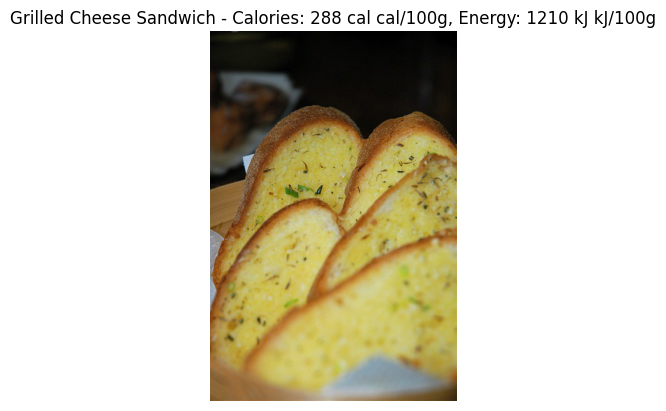

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# 加载模型
model_path = r'C:\Users\Jiang\flask-vue-crud\data\food-101\final_model.hdf5'  # Adjust with your model's filepath
model = load_model(model_path)

# 读取CSV文件并创建食物名称到卡路里和千焦的映射
calories_df = pd.read_csv(r'C:\Users\Jiang\flask-vue-crud\data\calories.csv')
calories_dict = pd.Series(calories_df.Cals_per100grams.values,index=calories_df.FoodItem).to_dict()
kj_dict = pd.Series(calories_df.KJ_per100grams.values,index=calories_df.FoodItem).to_dict()

# 定义食品名称格式转换函数
def format_food_name(name):
    return name.replace("_", " ").title()

# 修改预测函数以显示食品名称、卡路里和千焦
def predict_class(model, images, food_list, calories_dict, kj_dict, show=True):
    for img_path in images:
        img = image.load_img(img_path, target_size=(224, 224))
        img = image.img_to_array(img)                    
        img = np.expand_dims(img, axis=0)         
        img /= 255.

        pred = model.predict(img)
        index = np.argmax(pred)
        formatted_name = format_food_name(food_list[index])
        calories = calories_dict.get(formatted_name, "Unknown")
        kj = kj_dict.get(formatted_name, "Unknown")

        if show:
            img_plot = plt.imread(img_path)
            plt.imshow(img_plot)                           
            plt.axis('off')
            plt.title(f"{formatted_name} - Calories: {calories} cal/100g, Energy: {kj} kJ/100g")
            plt.show()

# 创建下载的图片列表并测试训练好的模型
images = ['cupcakes.jpg', 'springrolls.jpg', 'garlicbread.jpg']
predict_class(model, images, food_list, calories_dict, kj_dict, True)
